In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Bengaluru_House_Data.csv")
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
data.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


# Data Preprocessing

In [4]:
# dropping non-useful features

df = data.drop(['area_type','availability','society','balcony'],axis=1)
df.shape

(13320, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   size        13304 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13247 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB


In [6]:
# checking for null count

df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
for i in df.columns:
    if df[i].isnull().sum() > 0:
        print(i, "-->", df[i].isnull().sum() , "-->", int(np.round(df[i].isnull().sum()/len(df),2)*100),"%")

location --> 1 --> 0 %
size --> 16 --> 0 %
bath --> 73 --> 1 %


In [8]:
# dropping null values

df = df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df.head(1)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07


In [10]:
# extracting bedroom numbers from size feature 

df['bedrooms'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [11]:
# dropping size feature

df.drop(["size"],inplace=True,axis=1)

In [12]:
df.head(1)

,location,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,1056,2.0,39.07,2


#### Exploring unique values in each feature.

In [13]:
df['total_sqft'].unique() 

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [14]:
df['bath'].unique() 

array([ 2.,  5.,  3.,  4.,  6.,  1.,  9.,  8.,  7., 11., 10., 14., 27.,
       12., 16., 40., 15., 13., 18.])

In [15]:
df['price'].unique() 

array([ 39.07, 120.  ,  62.  , ...,  40.14, 231.  , 488.  ])

#### Converting range of price into average of upper bound and lower bound. Ex. '1133 - 1384' = (1133+1384)/2

In [16]:
def total_sqft_cleaning(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [17]:
df["total_sqft"] = df["total_sqft"].apply(total_sqft_cleaning)

In [18]:
df.head(10)

,location,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
5,Whitefield,1170.0,2.0,38.00,2
6,Old Airport Road,2732.0,4.0,204.00,4
7,Rajaji Nagar,3300.0,4.0,600.00,4
8,Marathahalli,1310.0,3.0,63.25,3
9,Gandhi Bazar,1020.0,6.0,370.00,6


In [19]:
df.isnull().sum()

location       0
total_sqft    46
bath           0
price          0
bedrooms       0
dtype: int64

In [20]:
df = df.dropna()  

In [21]:
# adding price_per_sqft feature 

df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,location,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


#### grouping locations whose count is less than 10 as "Others".

In [22]:
df["location"] = df["location"].apply(lambda x: x.strip())
location_count = df['location'].value_counts(ascending=False)
location_count

Whitefield                                  533
Sarjapur  Road                              392
Electronic City                             304
Kanakpura Road                              264
Thanisandra                                 235
                                           ... 
Haralur Road,                                 1
Adugodi                                       1
Rammana Layout                                1
Double Road                                   1
Viswapriyanagar.begur Road.bommanahalli.      1
Name: location, Length: 1287, dtype: int64

In [23]:
len(location_count[location_count>10])

240

In [24]:
len(location_count[location_count<=10])

1047

In [25]:
location_count_ls_10 = location_count[location_count<=10]
location_count_ls_10

Nagappa Reddy Layout                        10
BTM 1st Stage                               10
Kalkere                                     10
Dodsworth Layout                            10
Dairy Circle                                10
                                            ..
Haralur Road,                                1
Adugodi                                      1
Rammana Layout                               1
Double Road                                  1
Viswapriyanagar.begur Road.bommanahalli.     1
Name: location, Length: 1047, dtype: int64

In [26]:
df["location"] = df["location"].apply(lambda x: 'other' if x in location_count_ls_10 else x)
len(df.location.unique())

241

In [27]:
location_list = df["location"]

In [28]:
df.head(3)

,location,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556


In [29]:
test_df = df[df["total_sqft"]/df["bedrooms"]<350]

In [30]:
test_df =  test_df[(test_df.bedrooms > 3)]

In [31]:
test_df

,location,total_sqft,bath,price,bedrooms,price_per_sqft
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
89,Rajaji Nagar,710.0,6.0,160.0,6,22535.211268
...,...,...,...,...,...,...
13281,Margondanahalli,1375.0,5.0,125.0,5,9090.909091
13300,Hosakerehalli,1500.0,6.0,145.0,5,9666.666667
13303,Vidyaranyapura,774.0,5.0,70.0,5,9043.927649
13306,other,1200.0,5.0,325.0,4,27083.333333


#### We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These rows are unusual. We will treat this rows as outliers.

In [32]:
df.shape

(13200, 6)

In [33]:
df = df[~(df["total_sqft"]/df["bedrooms"]<300)]
df.shape

(12456, 6)

In [34]:
t = data.copy(deep=True)
t =  df[~((df["total_sqft"]/df["bedrooms"]<300) & (df.bedrooms > 3) )]
t.shape


(12456, 6)

In [35]:
df["price_per_sqft"].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

#### Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [36]:
def remove_outliers(df):
    new_df = pd.DataFrame()
    for key, values in df.groupby('location'):
        mu = np.mean(values.price_per_sqft)
        std = np.std(values.price_per_sqft)
        df1 = values[(values.price_per_sqft>(mu-std)) & (values.price_per_sqft<=(mu+std))]
        new_df = pd.concat([new_df,df1],ignore_index=True)
    return new_df

In [37]:
df = remove_outliers(df)
df.shape

(10242, 6)

In [38]:
df.head(3)

,location,total_sqft,bath,price,bedrooms,price_per_sqft
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333


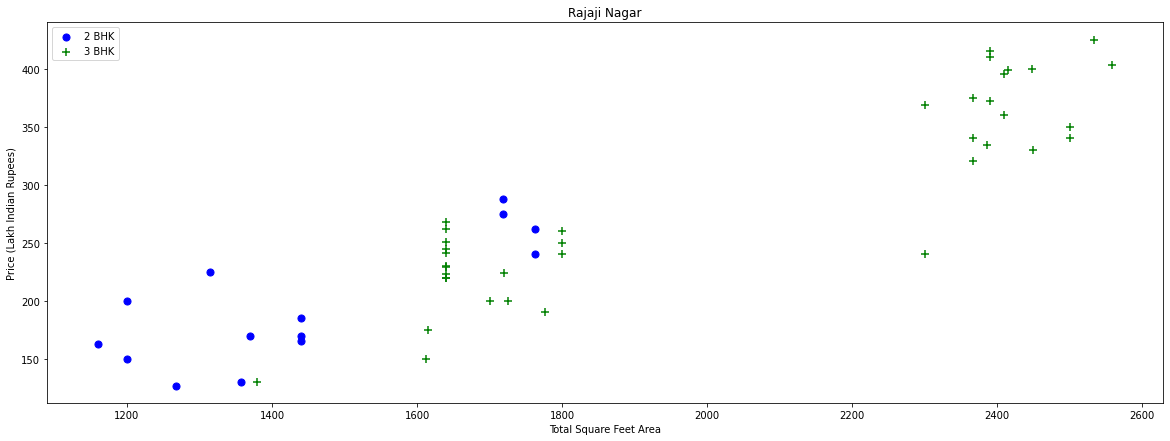

In [39]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bedrooms==2)]
    bhk3 = df[(df.location==location) & (df.bedrooms==3)]
    plt.figure(figsize=(20,7))
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df,"Rajaji Nagar")

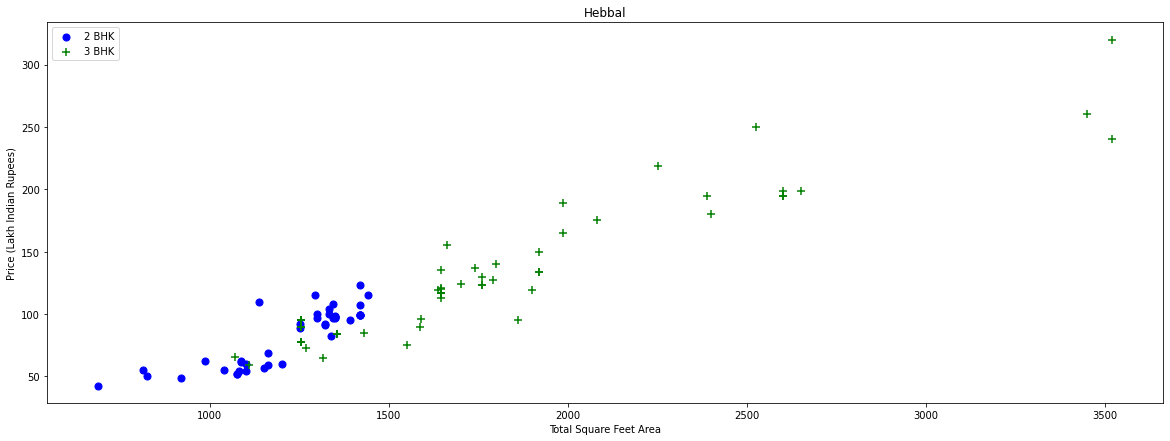

In [40]:
plot_scatter_chart(df,"Hebbal")

#### In above plots we can observe that 2 bhk flats has more price than 3 bhk flats in same area which is unusual. We will treat those values as outliers.

In [41]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bedrooms'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bedrooms'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [42]:
df = remove_bhk_outliers(df)
df.shape

(7317, 6)

#### Plots after removing outliers.

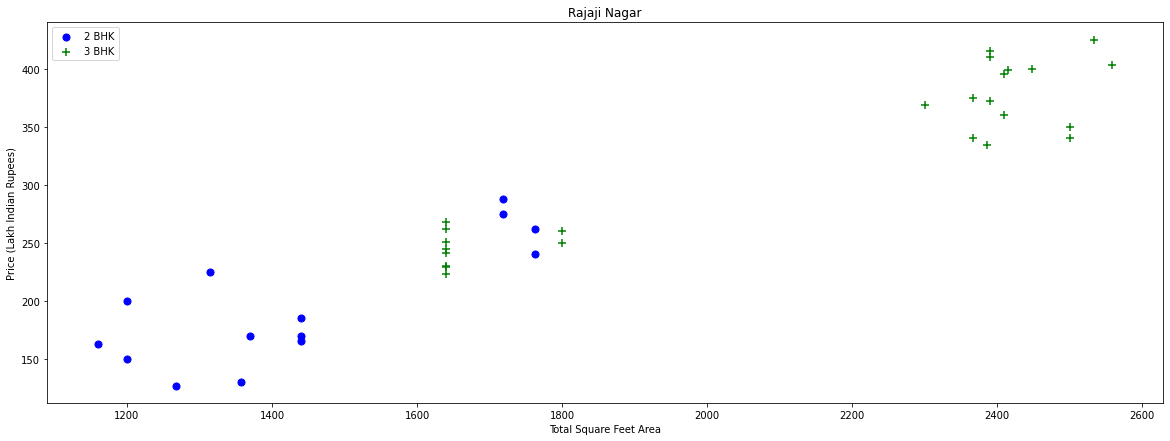

In [43]:
plot_scatter_chart(df,"Rajaji Nagar")

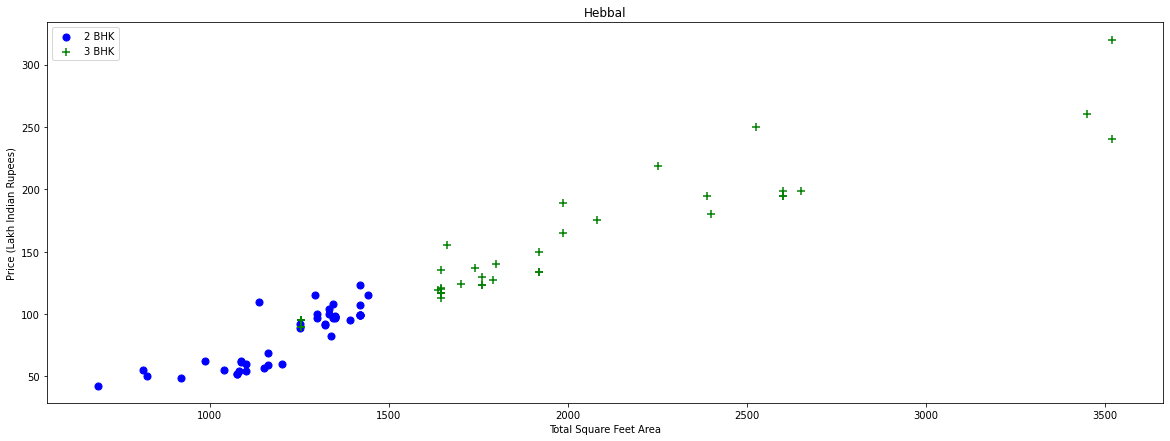

In [44]:
plot_scatter_chart(df,"Hebbal")

Text(0, 0.5, 'Count')

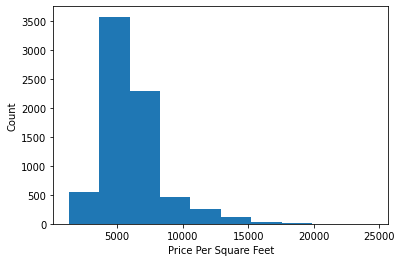

In [45]:
plt.hist(df.price_per_sqft)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

#### It is unusual to have 2 more bathrooms than number of bedrooms in a home. We will treat those records as outlier.

In [46]:
df["bath"].describe()

count    7317.000000
mean        2.452098
std         1.015090
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: bath, dtype: float64

In [47]:
df = df[df.bath<df.bedrooms+2]
df.shape

(7239, 6)

In [48]:
df = df.drop(['price_per_sqft'],axis='columns')
df.head(2)

,location,total_sqft,bath,price,bedrooms
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3


#### Using one hot encoding to convert categorical variable "location" into numeric.

In [49]:
dummie_data = pd.get_dummies(df.location)
dummie_data.head(2)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df = pd.concat([df,dummie_data.drop('other',axis=1)],axis=1)

In [51]:
df = df.drop('location',axis=1)
df.head(2)

,total_sqft,bath,price,bedrooms,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df.shape

(7239, 244)

# 

# Model Building and Evaluation

In [53]:
y = df[["price"]]
x = df.drop(['price'],axis=1)

In [54]:
# Splitting of dataset

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [55]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression(normalize=True)
lr_model.fit(x_train,y_train)

print("Linear Regression")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , lr_model.score(x_test, y_test))
print("train score " , lr_model.score(x_train, y_train))
print()
if abs((lr_model.score(x_train, y_train))-(lr_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Linear Regression
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.8087560153181268
train score  0.8676423282599074

Overfiting or underfitting doesn't exist


In [56]:
from xgboost import XGBRegressor

xgboost_model = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=2,reg_alpha=0.00,n_jobs=4)
xgboost_model.fit(x_train,y_train)

print("XGBOOST")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , xgboost_model.score(x_test, y_test))
print("train score " , xgboost_model.score(x_train, y_train))
print()
if abs((xgboost_model.score(x_train, y_train))-(xgboost_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

XGBOOST
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.7485339389086048
train score  0.8637654867787414

Overfiting or underfitting doesn't exist


In [57]:
from sklearn.svm import SVR

svm_model = SVR(kernel="rbf")
svm_model.fit(x_train,y_train)
print("SVM")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , svm_model.score(x_test, y_test))
print("train score " , svm_model.score(x_train, y_train))
print()
if abs((svm_model.score(x_train, y_train))-(svm_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

SVM
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.49550112784543054
train score  0.5321521633743205

Overfiting or underfitting doesn't exist


In [58]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(x_train,y_train)

print("KNN")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , knn_model.score(x_test, y_test))
print("train score " , knn_model.score(x_train, y_train))
print()
if abs((knn_model.score(x_train, y_train))-(knn_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

KNN
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.6008269031067764
train score  0.7752546954656133

Overfiting or underfitting exist


In [59]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(x_train,y_train)

print("Random Forest")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , rf_model.score(x_test, y_test))
print("train score " , rf_model.score(x_train, y_train))
print()
if abs((rf_model.score(x_train, y_train))-(rf_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Random Forest
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.7155327162318492
train score  0.9635371083317903

Overfiting or underfitting exist


In [60]:
from sklearn.tree import DecisionTreeRegressor

decisiontree_model = DecisionTreeRegressor()
decisiontree_model.fit(x_train,y_train)

print("Decision Tree")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , decisiontree_model.score(x_test, y_test))
print("train score " , decisiontree_model.score(x_train, y_train))
print()
if abs((decisiontree_model.score(x_train, y_train))-(decisiontree_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Decision Tree
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.6667854616773412
train score  0.991436783425141

Overfiting or underfitting exist


In [61]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train,y_train)

print("LGBM")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , lgbm_model.score(x_test, y_test))
print("train score " , lgbm_model.score(x_train, y_train))
print()
if abs((lgbm_model.score(x_train, y_train))-(lgbm_model.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")     

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 5067, number of used features: 65
[LightGBM] [Info] Start training from score 96.239610
LGBM
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.6650379674981097
train score  0.8009150369370781

Overfiting or underfitting exist


In [62]:
from sklearn.linear_model import Lasso

Lmodel = Lasso(alpha=0.02)
Lmodel.fit(x_train,y_train)

print("Lasso")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , Lmodel.score(x_test, y_test))
print("train score " , Lmodel.score(x_train, y_train))
print()
if abs((Lmodel.score(x_train, y_train))-(Lmodel.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Lasso
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.8053614138865148
train score  0.8550031307984336

Overfiting or underfitting doesn't exist


In [63]:
from sklearn.linear_model import Ridge
Rmodel = Ridge(alpha =1.4)
Rmodel.fit(x_train,y_train)

print("Ridge")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , Rmodel.score(x_test, y_test))
print("train score " , Rmodel.score(x_train, y_train))
print()
if abs((Rmodel.score(x_train, y_train))-(Rmodel.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Ridge
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.8212032332225009
train score  0.861557234438919

Overfiting or underfitting doesn't exist


In [64]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha =0.05,l1_ratio=0.05)
enet.fit(x_train,y_train)

print("Elastic net")
print('-------------------------------------------------------')
print()

print("Scores")
print('-------------------------------------------------------')
print("test score " , enet.score(x_test, y_test))
print("train score " , enet.score(x_train, y_train))
print()
if abs((enet.score(x_train, y_train))-(enet.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Elastic net
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.6980103108297748
train score  0.7342307829067244

Overfiting or underfitting doesn't exist


In [65]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor

kfold = KFold(n_splits=10)

estimators = []
estimators.append(('ridge', Rmodel))
estimators.append(('lasso', Lmodel))
estimators.append(('lr', lr_model))

ensemble = VotingRegressor(estimators)
ensemble.fit(x_train,y_train)

print("Stacking")
print('-------------------------------------------------------')
print()
print("Scores")
print('-------------------------------------------------------')
print("test score " , ensemble.score(x_test, y_test))
print("train score " , ensemble.score(x_train, y_train))
print()
if abs((ensemble.score(x_train, y_train))-(ensemble.score(x_test, y_test))) > 0.12:
    print("Overfiting or underfitting exist")
else:
    print("Overfiting or underfitting doesn't exist")

Stacking
-------------------------------------------------------

Scores
-------------------------------------------------------
test score  0.8155930899096626
train score  0.8641817664284392

Overfiting or underfitting doesn't exist


In [66]:
model_name = ["linearRegression_model","xgboost_model","randomForest_model","knn_model","svm_model","decisiontree_model","lgbm_model","stacking_model","elasticnet_model","Lasso_model","Ridge_model"]
model_name2 = [lr_model,xgboost_model,rf_model,knn_model,svm_model,decisiontree_model,lgbm_model,ensemble,enet,Lmodel,Rmodel]
df = pd.DataFrame()
df["Model Name"] = [i for i in model_name]
df["Accuracy"] = [i.score(x_test,y_test) for i in model_name2]
df

,Model Name,Accuracy
0,linearRegression_model,0.808756
1,xgboost_model,0.748534
2,randomForest_model,0.715533
3,knn_model,0.600827
4,svm_model,0.495501
5,decisiontree_model,0.666785
6,lgbm_model,0.665038
7,stacking_model,0.815593
8,elasticnet_model,0.698010
9,Lasso_model,0.805361


In [ ]:
#### We can observe Ridge model is 

# Model Testing

In [73]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(x.columns==location)[0][0]

    X = np.zeros(len(x.columns))
    X[0] = sqft
    X[1] = bath
    X[2] = bhk
    if loc_index >= 0:
        X[loc_index] = 1

    return Rmodel.predict([X])[0]

In [75]:
predict_price('1st Phase JP Nagar',1000, 2, 2)[0]

95.63060272454149

In [ ]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

In [ ]:
predict_price('Indira Nagar',1000, 2, 2)

In [ ]:
predict_price('Indira Nagar',1000, 3, 3)

In [79]:
location_list

0        Electronic City Phase II
1                Chikka Tirupathi
2                     Uttarahalli
3              Lingadheeranahalli
4                        Kothanur
                   ...           
13315                  Whitefield
13316                       other
13317       Raja Rajeshwari Nagar
13318             Padmanabhanagar
13319                Doddathoguru
Name: location, Length: 13200, dtype: object

In [88]:
import joblib

In [81]:
joblib.dump(Rmodel,"Rmodel1.pkl")

['Rmodel1.pkl']

In [85]:
pd.to_pickle(x,"final_df.pkl")

In [87]:
pd.to_pickle(location_list,"final_location_list.pkl")